# Modelo de análise de sentimentos - AdTrack

Nesse notebook será contido o pipeline completo para gerar o modelo naive bayes com bag of words. Todo o desenvolvimento feito nas últimas 9 semanas está contido neste notebook, o objetivo é gerar o modelo .pickle a partir de uma base de dados previamente fornecida pelos parceiros de projeto. 

O motivo da escolha do modelo naive bayes foi que o mesmo obteve os melhores resultados com o pré processamento feito anteriormente, para mais detalhes dos outros modelos, análises gráficas do dataset e diferentes tratamentos do dataset acesse o readMe para mais detalhes. 


## Importando bibliotecas


Aqui são importadas as bibliotecas necessárias para realizar todo o processo contido no notebook. 
Caso não consiga executar alguma é só executar o comando :
```
pip install {nome da biblioteca}
```

In [3]:
import pandas as pd 
import numpy as np
import nltk
from sklearn.feature_extraction.text import CountVectorizer
import ast
import emoji
from nltk.tokenize import word_tokenize
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, recall_score, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt
import time
import pickle 

ModuleNotFoundError: No module named 'pandas'

## Pré processamento 


Para executar o notebook é necessário o arquivo. csv , o mesmo já foi feito o pré processamento antes, visto que nós classificamos novamente os sentimentos de forma manual e para isso foram removidas todas as postagens que não eram de autoria do parceiro @btgpactual. Porém o processamento se aplica igualmente a uma base que não tenha sido tratada. 




Para baixar o arquivo basta acessar o seguinte [link](https://drive.google.com/file/d/1Q3ZAA4q-ztKNKePnD2BcQyWWBjSRn5qJ/view?usp=sharing) o mesmo só é disponível para alunos e professores da turma por questões de segurança. 

Após efetuar o download só basta copiar o arquivo para a pasta “src” e começar a rodar todo o pipeline. 


In [2]:
# Abrindo o csv 
df = pd.read_csv('sentimento_revisado.csv')
df

NameError: name 'pd' is not defined

Como citado anteriormente, as colunas que já sofreram o processamento serão removidas para demonstrar todo o funcionamento do código. 

In [ ]:
df_inicial = df.drop(['texto_tokenizado', 'texto_e_palavra'], axis=1)
df

NameError: name 'df' is not defined

## Limpeza dos dados

A limpeza inicial remove as aspas dos nomes das colunas, todas as interações realizadas pelo autor 'btgpactual', comentários nulos (coluna 'texto') e qualquer interações que não sejam do tipo 'comentário' e 'resposta'

In [ ]:
# Esta função remove os dados que não serão utilizados para a análise
def clean_data(df):
    # Remove as aspas dos nomes das colunas
    df = df.rename(columns=lambda x: x.replace('\"', ''))
    # Remove comentários feito pelo btg
    dfWithoutAutor = df[df["autor"] != "btgpactual"]
    # Remove comentários nulos
    dfWithoutNull = dfWithoutAutor[dfWithoutAutor["autor"].notnull()]
    # Deixando apenas as interações do tipo comentário e resposta
    dfFinal = dfWithoutNull.loc[(dfWithoutNull['tipoInteracao'] == 'comentário') | (dfWithoutNull['tipoInteracao'] == 'resposta')]
    return dfFinal

**Caso de teste**


Para garantir o correto funcionamento das funções a utilização de casos de teste é primordial. Então, antes da aplicação das funções é feito o caso de teste para realmente testar o funcionamento e se o output das funções é o esperado.

Nesta etapa é esperado que a função remova todos comentários de autoria do @btgpactual, remoção de dados nulos e remoção de todas interações diferentes de 'comentário' e 'resposta'.

In [ ]:
# Criando um data frame de teste para validar o pré processamento
data_test = {'id': [1, 2, 3, 4, 5],
             'dataPublicada': ['03/01/2022', '03/04/2022', '03/07/2022', '03/10/2022', '31/12/2022'],
             'autor': ['btgpactual', 'robert87', 'grace46', 'william25', 'john23'],
             'texto': ["Obrigado, 🚀🚀💙", "Muito bom 👏👏👏👏", 
                       "💙Bom dia, preciso urgente do meu informe de rendimentos do BTLG11 , para declaração do meu IR. Já enviei vários e-mails e até o momento sem resposta. Telefone ninguém atende. Como faço? 🐸", "Pessoal, sempre muito bom mas se eu puder solicitar uma coisa seria legendas 😅", "Sempre é aproveitoso parar o q tá fazendo para ouvi-lo"],
             'sentimento': ['NEUTRAL', 'NEUTRAL', 'NEGATIVE', 'POSITIVE', 'POSITIVE'],
             'tipoInteracao': ["comentário", "comentário", "comentário", "marcação", "comentário"],
             'anomalia': [1, 0, 0, 1, 1],
             'probabilidadeAnomalia': [100, 20, 30, 100, 100],
             'linkPost': ['https://www.instagram.com/p/CapXhB5Lvas/#17935401550894179', 'https://www.instagram.com/p/CaqBiRpsYLm/', 'https://www.instagram.com/p/CaqBiRpsYLm/', 'https://www.instagram.com/p/CapXhB5Lvas/#17926096268158628', 'https://www.instagram.com/p/CaR1j2TuPpD/#17914683365221503'],
             'processado': [0,0,0,1,1],
             'contemHyperlink': [0,0,0,1,1]}
               
df_testing = pd.DataFrame(data_test)
df_testing

,id,dataPublicada,autor,texto,sentimento,tipoInteracao,anomalia,probabilidadeAnomalia,linkPost,processado,contemHyperlink
0,1,03/01/2022,btgpactual,"Obrigado, 🚀🚀💙",NEUTRAL,comentário,1,100,https://www.instagram.com/p/CapXhB5Lvas/#17935...,0,0
1,2,03/04/2022,robert87,Muito bom 👏👏👏👏,NEUTRAL,comentário,0,20,https://www.instagram.com/p/CaqBiRpsYLm/,0,0
2,3,03/07/2022,grace46,"💙Bom dia, preciso urgente do meu informe de re...",NEGATIVE,comentário,0,30,https://www.instagram.com/p/CaqBiRpsYLm/,0,0
3,4,03/10/2022,william25,"Pessoal, sempre muito bom mas se eu puder soli...",POSITIVE,marcação,1,100,https://www.instagram.com/p/CapXhB5Lvas/#17926...,1,1
4,5,31/12/2022,john23,Sempre é aproveitoso parar o q tá fazendo para...,POSITIVE,comentário,1,100,https://www.instagram.com/p/CaR1j2TuPpD/#17914...,1,1


In [ ]:
# Testando a função
clean_data_test = df_testing
cleaning_test = clean_data(clean_data_test)
cleaning_test

,id,dataPublicada,autor,texto,sentimento,tipoInteracao,anomalia,probabilidadeAnomalia,linkPost,processado,contemHyperlink
1,2,03/04/2022,robert87,Muito bom 👏👏👏👏,NEUTRAL,comentário,0,20,https://www.instagram.com/p/CaqBiRpsYLm/,0,0
2,3,03/07/2022,grace46,"💙Bom dia, preciso urgente do meu informe de re...",NEGATIVE,comentário,0,30,https://www.instagram.com/p/CaqBiRpsYLm/,0,0
4,5,31/12/2022,john23,Sempre é aproveitoso parar o q tá fazendo para...,POSITIVE,comentário,1,100,https://www.instagram.com/p/CaR1j2TuPpD/#17914...,1,1


Como esperado a função funcionou corretamente, então é possível prosseguir para as próximas etapas.

**Aplicando a função**

In [ ]:
# Aplicando a função no data set real que será utilizado para treinar o modelo
cleaning_output = clean_data(df_inicial)
cleaning_output

,dataPublicada,autor,texto,sentimento,tipoInteracao,anomalia,probabilidadeAnomalia,linkPost,processado,contemHyperlink,sentimento_revisto
0,"""2022-03-04 08:36:00""",lmviapiana,Minuto touro de ouro,POSITIVE,comentário,0,38,https://www.instagram.com/p/CapXhB5Lvas/#17977...,0,0,1.0
1,"""2022-03-03 21:10:00""",vanilson_dos,@ricktolledo Sim,NEUTRAL,resposta,0,17,https://www.instagram.com/p/CapXhB5Lvas/#17842...,0,0,0.0
2,"""2022-03-03 20:54:00""",ricktolledo,Queria saber se a Btg banking é a própria btg ...,POSITIVE,comentário,0,20,https://www.instagram.com/p/CapXhB5Lvas/#17935...,0,0,1.0
3,"""2022-03-03 16:11:00""",paularodrigues.invest,👏👏👏👏,NEUTRAL,comentário,0,15,https://www.instagram.com/p/CaptWrtOT8U/#17943...,0,0,1.0
4,"""2022-03-03 15:35:00""",rafael_miller,Vamos ajudar o Brasil na principal categoria d...,POSITIVE,comentário,0,41,https://www.instagram.com/p/CapoqJ3Ne7a/#17972...,0,0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...
5672,"""2022-11-30 07:48:00""",perspectiveinvestimentos,Excelente explicação,POSITIVE,comentário,0,15,https://www.instagram.com/p/ClgWR-Ov2H1/#18001...,0,0,NaN
5673,"""2022-11-30 08:42:00""",marlenenelso,Porque o brg tá diminuído o limite do cart...,NEGATIVE,comentário,1,53,https://www.instagram.com/p/ClgWR-Ov2H1/#17878...,0,0,NaN
5674,"""2022-11-30 11:27:00""",eduardocolares,Atendam o telefone pelo amor de Deus,POSITIVE,comentário,0,28,https://www.instagram.com/p/CllkSBOuKlJ/#17960...,0,0,NaN
5675,"""2022-11-30 12:18:00""",jayipacderota,Estou muito grato por todo o esforço que você ...,POSITIVE,comentário,1,52,https://www.instagram.com/p/CllkSBOuKlJ/#17960...,0,0,NaN


# Pré processamento

Por se tratarem de comentários de redes sociais, muitos comentários possuem emojis e, dessa maneira, foi decidido realizar o seu tratamento para incluí-los no modelo. Assim, criou-se um dicionário de emojis em português, que são traduzidos e devolvidos em uma nova coluna do dataframe: 'texto_e_emoji'

In [ ]:
# Dicionário com todos os emojis

emoji_dict = {
    '😀': 'feliz ',
    '😂': 'risos ',
    '😔': 'triste ',
    '👏': 'palmas ',
    '🥰': 'amável ',
    '💙': 'coração azul ',
    '🙏🏼': 'orando ',
    '✨': 'brilhando ',
    '🤮': 'nojo ',
    '🚀': 'foguete ',
    '👿': 'diabo ',
    '🤢': 'nojo ',
    '🔥': 'fogo ',
    '😡': 'fúria ',
    '😠': 'raiva ',
    '🤣': 'rindo ',
    '😃': 'feliz ',
    '😎': 'curtindo ',
    '😊': 'feliz ',
    '🤩': 'maravilhado ',
    '😋': 'delicioso ',
    '😆': 'risada ',
    '😌': 'calmo ',
    '🤔': 'pensativo ',
    '😷': 'máscara ',
    '🤣': 'muitoRiso ',
    '🥺': 'carinhoso ',
    '👍': 'positivo ',
    '🤯': 'menteExplodida ',
    '😅': 'alívio ',
    '🥰': 'carinhaComCoração ',
    '😓': 'suor ',
    '😑': 'tédio',
    '🤫': 'silêncio',
    '🤝': 'apertoDeMãos',
    '😊': 'sorriso',
    '😍': 'apaixonado',
    '😭': 'choro ',
    '🤗': 'abraço ',
    '🎉': 'festa ',
    '😎': 'descolado ',
    '😱': 'surpresa ',
    '😴': 'sono ',
    '🙌': 'celebração ',
    '🤔': 'pensativo ',
    '😘': 'beijo ',
    '🥳': 'festeiro ',
    '🙄': 'revirarOsOlhos ',
    '😌': 'alívio ',
    '🤫': 'segredo ',
    '😇': 'inocente ',
    '😂': 'muitoEngraçado ',
    '🤔': 'pensando ',
    '😴': 'sono ',
    '🤪': 'loucura ',
    '😢': 'decepcionadoAliviado ',
    '😬': 'nervoso ',
    '😌': 'alívio',
    '😔': 'triste ',
    '😞': 'desapontado ',
    '😢': 'choro ',
    '😭': 'chorando ',
    '😡': 'raiva ',
    '🤯': 'mente explodida ',
    '😳': 'surpreso ',
    '😱': 'gritando ',
    '😨': 'assustado ',
    '😴': 'sono ',
    '🥱': 'bocejando ',
    '🤢': 'enjoado ',
    '🤮': 'vomitando ',
    '🤧': 'espirro ',
    '🤒': 'doente ',
    '🤕': 'machucado ',
    '🤑': 'dinheiro ',
}

In [ ]:
# Função que converte os emojis em palavras 
def emoji_to_word(text):
    for emoji_code, emoji_word in emoji_dict.items():
        text = text.replace(emoji_code, emoji_word)
    return text

**Caso de Teste**

Nesta etapa é esperado que a função substitua todos os emojis por texto de acordo com o dicionário acima e seja criada uma nova coluna.

In [ ]:
# Testando a função 
emoji_test = cleaning_test
emoji_test['texto_e_emoji'] = emoji_test['texto'].apply(emoji_to_word)
emoji_test

,id,dataPublicada,autor,texto,sentimento,tipoInteracao,anomalia,probabilidadeAnomalia,linkPost,processado,contemHyperlink,texto_e_emoji
1,2,03/04/2022,robert87,Muito bom 👏👏👏👏,NEUTRAL,comentário,0,20,https://www.instagram.com/p/CaqBiRpsYLm/,0,0,Muito bom palmas palmas palmas palmas
2,3,03/07/2022,grace46,"💙Bom dia, preciso urgente do meu informe de re...",NEGATIVE,comentário,0,30,https://www.instagram.com/p/CaqBiRpsYLm/,0,0,"coração azul Bom dia, preciso urgente do meu i..."
4,5,31/12/2022,john23,Sempre é aproveitoso parar o q tá fazendo para...,POSITIVE,comentário,1,100,https://www.instagram.com/p/CaR1j2TuPpD/#17914...,1,1,Sempre é aproveitoso parar o q tá fazendo para...


Como esperado a função funcionou corretamente, então é possível prosseguir para as próximas etapas.

**Aplicando a função**

In [ ]:
# Aplicando a função e criando a colouna 'texto_e_emoji' como resultado
processing_output = cleaning_output
processing_output['texto_e_emoji'] = processing_output['texto'].apply(emoji_to_word)
processing_output

,dataPublicada,autor,texto,sentimento,tipoInteracao,anomalia,probabilidadeAnomalia,linkPost,processado,contemHyperlink,sentimento_revisto,texto_e_emoji,tokens_processados
0,"""2022-03-04 08:36:00""",lmviapiana,Minuto touro de ouro,POSITIVE,comentário,0,38,https://www.instagram.com/p/CapXhB5Lvas/#17977...,0,0,1.0,Minuto touro de ouro,"[minuto, touro, ouro]"
1,"""2022-03-03 21:10:00""",vanilson_dos,@ricktolledo Sim,NEUTRAL,resposta,0,17,https://www.instagram.com/p/CapXhB5Lvas/#17842...,0,0,0.0,@ricktolledo Sim,"[ricktolledo, sim]"
2,"""2022-03-03 20:54:00""",ricktolledo,Queria saber se a Btg banking é a própria btg ...,POSITIVE,comentário,0,20,https://www.instagram.com/p/CapXhB5Lvas/#17935...,0,0,1.0,Queria saber se a Btg banking é a própria btg ...,"[queria, saber, banking, administra]"
3,"""2022-03-03 16:11:00""",paularodrigues.invest,👏👏👏👏,NEUTRAL,comentário,0,15,https://www.instagram.com/p/CaptWrtOT8U/#17943...,0,0,1.0,palmas palmas palmas palmas,"[palmas, palmas, palmas, palmas]"
4,"""2022-03-03 15:35:00""",rafael_miller,Vamos ajudar o Brasil na principal categoria d...,POSITIVE,comentário,0,41,https://www.instagram.com/p/CapoqJ3Ne7a/#17972...,0,0,-1.0,Vamos ajudar o Brasil na principal categoria d...,"[vamos, ajudar, brasil, principal, categoria, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5672,"""2022-11-30 07:48:00""",perspectiveinvestimentos,Excelente explicação,POSITIVE,comentário,0,15,https://www.instagram.com/p/ClgWR-Ov2H1/#18001...,0,0,NaN,Excelente explicação,"[excelente, explicação]"
5673,"""2022-11-30 08:42:00""",marlenenelso,Porque o brg tá diminuído o limite do cart...,NEGATIVE,comentário,1,53,https://www.instagram.com/p/ClgWR-Ov2H1/#17878...,0,0,NaN,Porque o brg tá diminuído o limite do cart...,"[tá, diminuído, limite, cartão, sempre, pagamo..."
5674,"""2022-11-30 11:27:00""",eduardocolares,Atendam o telefone pelo amor de Deus,POSITIVE,comentário,0,28,https://www.instagram.com/p/CllkSBOuKlJ/#17960...,0,0,NaN,Atendam o telefone pelo amor de Deus,"[atendam, telefone, amor, deus]"
5675,"""2022-11-30 12:18:00""",jayipacderota,Estou muito grato por todo o esforço que você ...,POSITIVE,comentário,1,52,https://www.instagram.com/p/CllkSBOuKlJ/#17960...,0,0,NaN,Estou muito grato por todo o esforço que você ...,"[muito, grato, todo, esforço, você, rendeu, in..."


## Tokenização e remoção de stop words

A partir do tratamento de emojis, agora é aplicada a tokenização das frases, em que são separadas por palavras e, depois, removidas as palavras que não apresentam significado semântico relevante ao modelo, chamadas stop words, como por exemplo: 'de', 'para', 'ou' e todas as demais consideradas stop words pelo stakeholder. Assim, não foram utilizadas bibliotecas de stop words visando trazer uma solução mais customizada tendo em mente a indústria do parceiro.

In [ ]:
def processText(text):
    # Converter palavras da frase para minúsculas
    text = text.lower() 
    # Tokenizar o texto em palavras
    tokens = word_tokenize(text) 
    # Remover stopwords das palavras tokenizadas
    stop_words = ['@', 'banco', 'btg', 'brg', 'pactual', 'btgpactual','pq', 'q', 'pra', 'vcs', 'vc', 'i', 'p', 'kkk', 'y', 'of', 'n', 'a', 'à', 'as', 'o', 'os', 'e', 'aos', 'do', 'das', 'dos', 'das', 'de', 'deles', 'dela', 'deles', 'delas', 'para', 'que', 'em', 'algo', 'algum', 'alguma', 'alguns', 'algumas', 'aqui', 'aquele', 'aquela', 'aqueles', 'aquelas', 'aqui', 'aquilo', 'cá', 'com', 'como', 'cada', 'coisa', 'daquele', 'daquela', 'daquilo', 'daqueles', 'daquelas', 'desse', 'deste', 'dessa', 'desses', 'destes', 'destas', 'ele', 'eles', 'ela', 'elas', 'eu', 'nos', 'nós', 'vocês', 'voces', 'enquanto', 'era',  'está', 'estamos', 'estão', 'estar', 'estará', 'estive', 'estivemos', 'estiver', 'estivera', 'estiveram', 'estivéramos', 'estiverem', 'estivermos', 'estivesse','estivessem', 'estivéssemos', 'estiveste', 'estivestes', 'estou',  'fará', 'farta', 'farto', 'fez', 'fim', 'foi', 'fomos', 'for', 'fora', 'foram', 'fôramos', 'forem', 'formos', 'fosse', 'fossem', 'fôssemos','foste', 'fostes', 'fui', 'fôssemos', 'há', 'houve', 'hoje', 'isso', 'isto', 'já', 'lá', 'lhe', 'lhes', 'lo', 'logo',  'mas', 'me', 'mesma', 'mesmas', 'mesmo', 'mesmos', 'meu', 'meus',  'minha', 'minhas', 'na', 'no', 'nas', 'nos', 'naquela', 'naquelas', 'naquele', 'naqueles', 'nem', 'nessa', 'nessas', 'nesse', 'nesses', 'nesta', 'nestas', 'neste', 'nestes', 'ninguém', 'nosso', 'nossa', 'nossos', 'nossas', 'num', 'numa', 'outra', 'outras', 'outro', 'outros', 'pela', 'pelo', 'perante', 'pois', 'ponto', 'pontos', 'por', 'porém', 'porque', 'porquê', 'própria', 'próprio', 'próprias', 'próprios', 'qual', 'quando', 'quanto', 'quantos', 'quantas', 'quê', 'quem', 'quer', 'quereis', 'querem', 'queremas', 'quis', 'quisemos', 'quiser', 'quisera', 'quiseram','quiséramos', 'quiserem', 'quisermos', 'quisésseis', 'quiséssemos', 'quiseste', 'quisestes', 'quiseste','quisestes', 'quizer', 'quizeram', 'quizerem', 'quizermos', 'quizesse', 'quizessem', 'quizéssemos', 'são', 'se', 'seja', 'sejam', 'sejamos', 'sem', 'sendo', 'ser', 'será', 'serão', 'será', 'seriam', 'seríamos','serias', 'seríeis', 'sete', 'seu', 'seus', 'sob', 'sobre', 'sois', 'só','somos', 'sou', 'sua', 'suas', 'tal', 'talvez', 'também', 'te', 'tem', 'têm', 'temos', 'tendes', 'tenha', 'tenham', 'tenhamos', 'tenho', 'tens', 'ter', 'terá', 'terão','terá', 'teriam', 'teríamos', 'terias', 'teríeis', 'teu', 'teus', 'teve', 'tivemos', 'tiver', 'tivera','tiveram', 'tivéramos', 'tiverem', 'tivermos', 'tivesse', 'tivessem', 'tivéssemos', 'tiveste', 'tivestes','tiveste', 'tivestes', 'um', 'uma', 'umas', 'uns','é' ]
    # Retorna a lista de comentários sem as palavras setadas para serem removidas
    tokens = [token for token in tokens if token not in stop_words if not token.startswith('@') and token.isalpha()]
    # Retorna o resultado da frase tokenizada, sem stopWords
    return tokens

**Caso de Teste**

Nesta etapa é esperado que a função deixe todos os textos da coluna 'texto_e_emoji' em minúsculo, tokenize o texto, remova todas stop words, retire todas as marcações que utilizam @ e remova todos tokens que não sejam letras do alfabeto. 

In [ ]:
# Aplicando a função no caso de teste e criando a coluna 'tokens_processados'
emoji_test['tokens_processados'] = emoji_test['texto_e_emoji'].apply(processText)
emoji_test.reset_index(drop=True, inplace=True)
emoji_test

,id,dataPublicada,autor,texto,sentimento,tipoInteracao,anomalia,probabilidadeAnomalia,linkPost,processado,contemHyperlink,texto_e_emoji,tokens_processados
0,2,03/04/2022,robert87,Muito bom 👏👏👏👏,NEUTRAL,comentário,0,20,https://www.instagram.com/p/CaqBiRpsYLm/,0,0,Muito bom palmas palmas palmas palmas,"[muito, bom, palmas, palmas, palmas, palmas]"
1,3,03/07/2022,grace46,"💙Bom dia, preciso urgente do meu informe de re...",NEGATIVE,comentário,0,30,https://www.instagram.com/p/CaqBiRpsYLm/,0,0,"coração azul Bom dia, preciso urgente do meu i...","[coração, azul, bom, dia, preciso, urgente, in..."
2,5,31/12/2022,john23,Sempre é aproveitoso parar o q tá fazendo para...,POSITIVE,comentário,1,100,https://www.instagram.com/p/CaR1j2TuPpD/#17914...,1,1,Sempre é aproveitoso parar o q tá fazendo para...,"[sempre, aproveitoso, parar, tá, fazendo]"


Como esperado a função funcionou corretamente, então é possível prosseguir para as próximas etapas.

**Aplicando a função**

In [ ]:
#Aplicar a função em uma única variável para aplicar nos modelos
processed_tokens = processing_output['texto_e_emoji'].apply(processText)
processed_tokens

0                                   [minuto, touro, ouro]
1                                      [ricktolledo, sim]
2                    [queria, saber, banking, administra]
3                        [palmas, palmas, palmas, palmas]
4       [vamos, ajudar, brasil, principal, categoria, ...
                              ...                        
5672                              [excelente, explicação]
5673    [tá, diminuído, limite, cartão, sempre, pagamo...
5674                      [atendam, telefone, amor, deus]
5675    [muito, grato, todo, esforço, você, rendeu, in...
5676    [morning, call, não, mais, aparecendo, spotify...
Name: texto_e_emoji, Length: 5677, dtype: object

In [ ]:
# Aplicando a função no dataset original para criar a coluna

processing_output['tokens_processados'] = processing_output['texto_e_emoji'].apply(processText)
processing_output.reset_index(drop=True, inplace=True)
processing_output


,dataPublicada,autor,texto,sentimento,tipoInteracao,anomalia,probabilidadeAnomalia,linkPost,processado,contemHyperlink,sentimento_revisto,texto_e_emoji,tokens_processados
0,"""2022-03-04 08:36:00""",lmviapiana,Minuto touro de ouro,POSITIVE,comentário,0,38,https://www.instagram.com/p/CapXhB5Lvas/#17977...,0,0,1.0,Minuto touro de ouro,"[minuto, touro, ouro]"
1,"""2022-03-03 21:10:00""",vanilson_dos,@ricktolledo Sim,NEUTRAL,resposta,0,17,https://www.instagram.com/p/CapXhB5Lvas/#17842...,0,0,0.0,@ricktolledo Sim,"[ricktolledo, sim]"
2,"""2022-03-03 20:54:00""",ricktolledo,Queria saber se a Btg banking é a própria btg ...,POSITIVE,comentário,0,20,https://www.instagram.com/p/CapXhB5Lvas/#17935...,0,0,1.0,Queria saber se a Btg banking é a própria btg ...,"[queria, saber, banking, administra]"
3,"""2022-03-03 16:11:00""",paularodrigues.invest,👏👏👏👏,NEUTRAL,comentário,0,15,https://www.instagram.com/p/CaptWrtOT8U/#17943...,0,0,1.0,palmas palmas palmas palmas,"[palmas, palmas, palmas, palmas]"
4,"""2022-03-03 15:35:00""",rafael_miller,Vamos ajudar o Brasil na principal categoria d...,POSITIVE,comentário,0,41,https://www.instagram.com/p/CapoqJ3Ne7a/#17972...,0,0,-1.0,Vamos ajudar o Brasil na principal categoria d...,"[vamos, ajudar, brasil, principal, categoria, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5672,"""2022-11-30 07:48:00""",perspectiveinvestimentos,Excelente explicação,POSITIVE,comentário,0,15,https://www.instagram.com/p/ClgWR-Ov2H1/#18001...,0,0,NaN,Excelente explicação,"[excelente, explicação]"
5673,"""2022-11-30 08:42:00""",marlenenelso,Porque o brg tá diminuído o limite do cart...,NEGATIVE,comentário,1,53,https://www.instagram.com/p/ClgWR-Ov2H1/#17878...,0,0,NaN,Porque o brg tá diminuído o limite do cart...,"[tá, diminuído, limite, cartão, sempre, pagamo..."
5674,"""2022-11-30 11:27:00""",eduardocolares,Atendam o telefone pelo amor de Deus,POSITIVE,comentário,0,28,https://www.instagram.com/p/CllkSBOuKlJ/#17960...,0,0,NaN,Atendam o telefone pelo amor de Deus,"[atendam, telefone, amor, deus]"
5675,"""2022-11-30 12:18:00""",jayipacderota,Estou muito grato por todo o esforço que você ...,POSITIVE,comentário,1,52,https://www.instagram.com/p/CllkSBOuKlJ/#17960...,0,0,NaN,Estou muito grato por todo o esforço que você ...,"[muito, grato, todo, esforço, você, rendeu, in..."


### Conclusão pré processamento 

Com as etapas acima prontas o pré processamento está concluido. Assim, foi possível remover comentários que não fazem sentido para o treino do modelo, tratamento de emojis, remoção de stop words customizada e a tokenização dos comentários. 

## Aplicação do modelo Bag of Words

A função abaixo vetoriza todas as palavras contidas na coluna 'tokens_processados' e retorna um vocabulário a partir delas. Posteriormente esses vetores serão utilizados para a aplicação dos modelos.

In [ ]:
#A função abaixo obtém o dicionário e os vetores para, posteriormente, ser aplicado nos modelos

def bag_of_words(frases):
    vectorizer = CountVectorizer()
    frases = [' '.join(tokens) for tokens in frases]
    bow_representation = vectorizer.fit_transform(frases)
    dictionary = vectorizer.vocabulary_

    return bow_representation, dictionary


In [ ]:
bow_representation2, dictionary2 = bag_of_words(processed_tokens)
bow_representation2, dictionary2

(<5677x9429 sparse matrix of type '<class 'numpy.int64'>'
 	with 49416 stored elements in Compressed Sparse Row format>,
 {'minuto': 5881,
  'touro': 8730,
  'ouro': 6445,
  'ricktolledo': 7877,
  'sim': 8206,
  'queria': 7420,
  'saber': 7970,
  'banking': 1042,
  'administra': 202,
  'palmas': 6515,
  'vamos': 9023,
  'ajudar': 330,
  'brasil': 1267,
  'principal': 7144,
  'categoria': 1555,
  'automobilismo': 936,
  'mundo': 6024,
  'ambev': 458,
  'xpinvestimentos': 9340,
  'havanoficial': 4497,
  'bancodobrasil': 1017,
  'clarobrasi': 1724,
  'nubank': 6241,
  'itau': 5061,
  'santander': 8023,
  'wegelectric': 9306,
  'tanta': 8475,
  'conta': 2147,
  'digital': 2870,
  'dando': 2456,
  'baile': 992,
  'bancos': 1022,
  'raios': 7463,
  'continuam': 2166,
  'itaú': 5066,
  'hora': 4556,
  'dar': 2465,
  'adeus': 185,
  'escolha': 3432,
  'bancointer': 1018,
  'feliz': 3909,
  'carinhacomcoração': 1512,
  'itaufoi': 5063,
  'ruim': 7948,
  'desde': 2695,
  'sempre': 8115,
  'nunca

In [ ]:
df_revised_feeling = processing_output

Acurácia:, 71.65%
Recall:, 71.65%


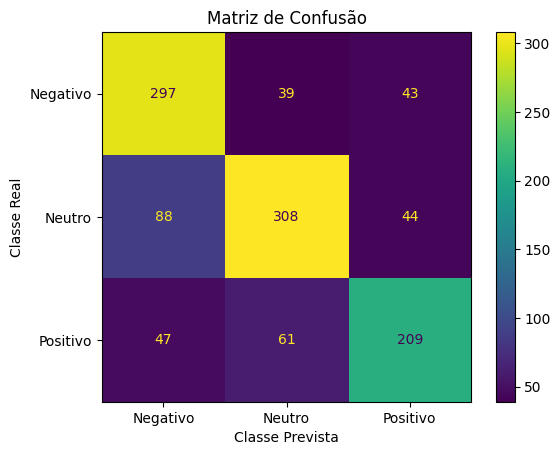

Tempo de execução: 0.12801 segundos


In [ ]:
encoder = LabelEncoder()
numeric_sentiment = encoder.fit_transform(df_revised_feeling['sentimento'])

# Dividir os dados em treino e teste
X_treino, X_teste, y_treino, y_teste = train_test_split(bow_representation2, numeric_sentiment, test_size=0.2, random_state=42)

# Criar e treinar o modelo Naive Bayes
model = MultinomialNB()
start_time = time.time()
model.fit(X_treino, y_treino)

# Fazer a predição usando os dados de teste
prediction = model.predict(X_teste)

# Avaliar a acurácia do modelo
accuracy = (prediction == y_teste).mean()
print(f"Acurácia:, {accuracy:.2%}")

# Calcular o recall
recall = recall_score(y_teste, prediction, average='weighted')
print(f"Recall:, {recall:.2%}")
# Calcular a matriz de confusão
confusion_matrix = confusion_matrix(y_teste, prediction)

# Mapear os valores originais para os rótulos desejados
mapping = {0: 'Negativo', 1: 'Neutro', 2: 'Positivo'}
mapped_confusion_matrix = np.vectorize(mapping.get)(confusion_matrix)

# Criar a matriz de confusão no estilo desejado
cm = ConfusionMatrixDisplay(confusion_matrix, display_labels=['Negativo', 'Neutro', 'Positivo'])
cm.plot()
cm.ax_.set(
    title='Matriz de Confusão',
    xlabel='Classe Prevista',
    ylabel='Classe Real'
)
plt.show()


end_time = time.time()
execution_time = end_time - start_time
print(f"Tempo de execução: {execution_time:.5f} segundos")


# Após treinar o modelo
with open('modelo_naive_bayes.pkl', 'wb') as file:
    pickle.dump(model, file)
